# Preprocessing data

Filtering data, splitting datasets and creating clustering data and num. features normalization data.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data/autos.csv', encoding='cp1252', index_col=None)

In [3]:
# Brands selection and remove outliers
data = data.loc[(data.brand.isin(['ford','opel','volkswagen','renault'])) & (data.price < 60000) & (data.price > 100),]
data = data.loc[(data.yearOfRegistration >= 1970) & (data.yearOfRegistration <= 2017)]
# replace 'andere' (otro)
data.loc[data.model == 'andere', 'model'] = np.nan
data.loc[data.gearbox == 'andere', 'gearbox'] = np.nan
data.loc[data.vehicleType == 'andere', 'vehicleType'] = np.nan
data.loc[data.fuelType == 'andere', 'fuelType'] = np.nan
data.loc[data.notRepairedDamage == 'andere', 'notRepairedDamage'] = np.nan

data = data.loc[:,['price','yearOfRegistration','brand','model','kilometer','powerPS','abtest', 'fuelType', 'vehicleType', 'gearbox','notRepairedDamage']]

data.shape

(153514, 11)

In [4]:
# Change language
translations = [
    ('andere', 'other'), ('ja', 'yes'), ('nein', 'no'), ('benzin', 'gasoline'), ('cng', 'natural gas'),
    ('elektro', 'electric'), ('lpg', 'autogas'), ('automatik', 'automatic'), ('manuell', 'manual')
]

for t in translations:
    data = data.replace(t[0], t[1])

In [5]:
# Split data
train, test = train_test_split(data, test_size=0.3, random_state=666)
train, val = train_test_split(train, test_size=0.2, random_state=666)

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

# save data
train.to_csv('data/train.csv', sep=',', index=False)
val.to_csv('data/val.csv', sep=',', index=False)
test.to_csv('data/test.csv', sep=',', index=False)

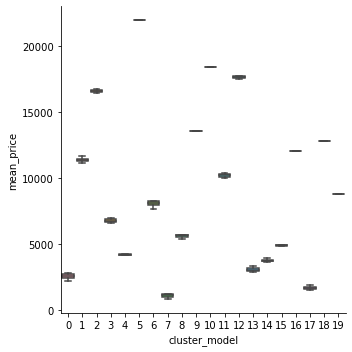

In [6]:
# Clustering categorical features

## Model
model_price_train = train.copy().dropna().loc[:,['model','price']]
model_price_train = model_price_train.groupby(['model']).mean()

model_clustering = KMeans(n_clusters=20, random_state=666)
model_clustering.fit(np.expand_dims(model_price_train.price.values, axis=1))
models_clustered = model_clustering.predict(np.expand_dims(model_price_train.price.values, axis=1))

model_clusters = pd.DataFrame({'model': model_price_train.index.values, 'cluster_model': models_clustered, 'mean_price': model_price_train.loc[:,'price']}).reset_index(drop=True)

sns.catplot(x='cluster_model', y='mean_price', kind="box", data=model_clusters)
plt.show()

###########
model_clusters.loc[:,['cluster_model', 'model']].to_csv('data/model_clusters.csv', sep=',', index=False)
###########

In [7]:
# Normalize numerical features
numerical_features = ['yearOfRegistration', 'powerPS', 'kilometer']

train.yearOfRegistration = 2017 - train.yearOfRegistration

numerical_features_normalization = pd.DataFrame({
    'feature': numerical_features,
    'mean': [np.mean(train[x]) for x in numerical_features],
    'std': [np.std(train[x]) for x in numerical_features]
})

numerical_features_normalization

# save normalization parameters
###########
numerical_features_normalization.to_csv('data/numerical_features_normalization.csv', sep=",", index=False)
###########